# Exploring aerosol data from DSCOVR EPIC Level 2 Aerosol Version 3

## Summary

We investigate the time lag between wildfire smoke detected by satellite scans and the corresponding readings from ground-based sensors. This analysis is crucial for understanding the behavior and transport of wildfire smoke plumes as they descend from the atmosphere to ground level, impacting air quality. We utilize satellite-derived Aerosol Index (AI) data, which indicates the presence of aerosols in the atmosphere, and ground-based Particulate Matter (PM) measurements, particularly PM2.5, to quantify smoke concentrations at the surface.
To analyze the time lag, we first normalize the AI units from satellite data and PM2.5 units from the ground sensors to create comparable time series. By shifting the ground sensor data over a range of time intervals, we aim to identify the optimal lag where the ground-based PM2.5 readings align with peaks in the satellite-derived AI values. This approach allows us to estimate the delay between smoke detection in the upper atmosphere and its eventual impact on air quality at the surface. Various statistical methods, such as cross-correlation, are employed to quantify this time lag and improve the predictive understanding of smoke dispersion patterns.

## Dataset Information

"DSCOVR_EPIC_L2_AER_03 is the Deep Space Climate Observatory (DSCOVR) Enhanced Polychromatic Imaging Camera (EPIC) Level 2 UV Aerosol Version 3 data product. Observations for this data product are at 340 and 388 nm and are used to derive near UV (ultraviolet) aerosol properties. The EPIC aerosol retrieval algorithm (EPICAERUV) uses a set of aerosol models to account for the presence of carbonaceous aerosols from biomass burning and wildfires (BIO), desert dust (DST), and sulfate-based (SLF) aerosols. These aerosol models are identical to those assumed in the OMI (Ozone Monitoring Instrument) algorithm (Torres et al., 2007; Jethva and Torres, 2011)." ([Source](https://asdc.larc.nasa.gov/project/DSCOVR/DSCOVR_EPIC_L2_AER_03))

This requires the data granules from [DSCOVR EPIC Level-2](https://cmr.earthdata.nasa.gov/search/concepts/C1962643459-LARC_ASDC.html) to have been downloaded into a local directory.

- Created: 2023
- Last Modified: 2024 December 27
- Authors: Jackson Baeza and Hazem Mahmoud

# Section 1:

## 1. Import Required Packages

In [ ]:
import re
from datetime import datetime
from glob import glob
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import earthaccess

# For the timeseries section
from scipy import spatial

# For the timeseries section, to compare with EPA Air Quality data
import pyrsig

# Fot the animation section
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter

## 2. Download data files

This section defines the time, and location to pull the data files from. After running once there is no reason to run this again. 
Also this section can be altered to change the type of data I am pulling

In [2]:
data_dir = Path("data/dscovr/").resolve()

In [3]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [4]:
collection_id = 'C1962643459-LARC_ASDC'

# Bounds within which we search for data granules
date_start = "2023-06-02 00:00"
date_end = "2023-06-15 23:59"
date_range = (date_start, date_end)
bbox = (-79, 34, -73, 40)  # minLon, minLat, maxLon, maxLat
# extent = [-79, -73, 35, 39.5]               # extend = [minLon, maxLon, minLat, maxLat]

# Find the data granules and their links
results = earthaccess.search_data(
    concept_id = collection_id,
    temporal = date_range,
    bounding_box = bbox,
)

Granules found: 163


**!!! Warning !!! This next cell can take a long time.  It needs to be run once, but then should be commented-out if the data files are already in a local directory.**

In [5]:
# Download the files
downloaded_files = earthaccess.download(
     results,
     local_path=data_dir,
 )

 Getting 163 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/163 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/163 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/163 [00:00<?, ?it/s]

In [6]:
# Return the list of files that are present
pattern = re.compile(r"DSCOVR_EPIC_L2_AER_03_([0-9]+)_03")  # the capture group is a datetime timestamp

file_list = list(data_dir.glob("DSCOVR_EPIC_L2_AER_*.he5"))
num_files = len(file_list)

# These are the paths to groups *within* each HDF file
data_fields_path = 'HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields'
geolocations_path = 'HDFEOS/SWATHS/Aerosol NearUV Swath/Geolocation Fields'

## 3. Wrangling data into Zarr stores

In this section, the HDF files are converted to Zarr stores to enable faster access for data manipulation later in the notebook.

In [7]:
def convert_hdf_to_xrds(filepath: Path, group_path: str) -> xr.Dataset:
    """Converts a HDF group into an xarray Dataset with an added time dimension

    Parameters
    ----------
    filepath : pathlib.Path
        The path to a DSCOVR EPIC HDF file
    group_path : str
        The internal path to a group, e.g., 'HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields'
    """
    # The filename's datetime string is converted into a datetime timestamp
    timestamp = pattern.findall(str(fp.stem))[0]
    timestamp_dt = datetime.strptime(timestamp, "%Y%m%d%H%M%S")

    # Note: the netCDF library works to access these datasets, so we just use it instead of h5py.
    with nc.Dataset(filepath) as ds:
        grp = ds[group_path]

        # The HDF group is converted into an xarray Dataset object, and then
        #     a new singleton 'time' dimension is added to the Dataset with the timestamp as its only value.
        grp_ds = (
            xr.open_dataset(xr.backends.NetCDF4DataStore(grp))
            .expand_dims(time=[timestamp_dt], axis=0)
        )

    return grp_ds

In [8]:
def convert_nc_to_xrds(filepath: Path, group_path: str) -> xr.Dataset:
    """Converts a HDF group into an xarray Dataset with an added time dimension
 
    Parameters
    ----------
    filepath : pathlib.Path
        The path to a DSCOVR EPIC HDF file
    group_path : str
        The internal path to a group, e.g., 'HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields'
    """
    # The filename's datetime string is converted into a datetime timestamp
    timestamp = pattern.findall(str(fp.stem))[0]
    timestamp_dt = datetime.strptime(timestamp, "%Y%m%d%H%M%S")
 
    # Note: the netCDF library works to access these datasets, so we just use it instead of h5py.
    with nc.Dataset(filepath) as ds:
        grp = ds[group_path]
 
        # The HDF group is converted into an xarray Dataset object, and then
        #     a new singleton 'time' dimension is added to the Dataset with the timestamp as its only value.
        grp_ds = (
            xr.open_dataset(xr.backends.NetCDF4DataStore(grp))
            .expand_dims(time=[timestamp_dt], axis=0)
        )
 
    return grp_ds

**!!! Warning !!! This next cell can take a long time.  It needs to be run once, but then should be commented-out if the zarr files already exist.**

In [9]:
print("Extracting groups...")

idcs_to_do = range(0, len(file_list))
for idx in tqdm(idcs_to_do, total=len(idcs_to_do)):
    fp = file_list[idx]
    (
        convert_hdf_to_xrds(fp, data_fields_path)
         .rename({"phony_dim_0": "XDim",
                  "phony_dim_1": "YDim",
                  "phony_dim_2": "nLayers",
                  "phony_dim_3": "nWave3" ,
                  "phony_dim_4": "nWave2"})
    ).merge(
        (convert_nc_to_xrds(fp, geolocations_path)
          .rename({"phony_dim_5": "XDim",
                   "phony_dim_6": "YDim"})
        )
    ).to_zarr(f"zStore01/zarr_2024_07_09_#{idx:03}.zarr")
    
    #if idx > 2:
    #    break
print("Done extracting groups.")

Extracting groups...


  0%|          | 0/163 [00:00<?, ?it/s]

Done extracting groups.


## 4. Now Open the dataset

This will load the Zarr files from the local saved, and then look at some of the values

In [2]:
mfds = xr.open_mfdataset(glob("zStore01/zarr_2024_07_09_#*.zarr"), 
                         engine='zarr', combine='by_coords')
mfds

<xarray.Dataset> Size: 298GB
Dimensions:                         (time: 163, XDim: 2048, YDim: 2048,
                                     nLayers: 5, nWave3: 3, nWave2: 2)
Coordinates:
  * time                            (time) datetime64[ns] 1kB 2023-06-02T10:1...
Dimensions without coordinates: XDim, YDim, nLayers, nWave3, nWave2
Data variables: (12/36)
    AIRSCO_Flags                    (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    AIRSL3COvalue                   (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    AerosolAbsOpticalDepthVsHeight  (time, XDim, YDim, nLayers, nWave3) float32 41GB dask.array<chunksize=(1, 256, 512, 2, 1), meta=np.ndarray>
    AerosolCorrCloudOpticalDepth    (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    AerosolOpticalDepthOverCloud    (time, XDim, YDim, nWave3) float32 8GB dask.array<chunksize=(1, 512, 512, 1), meta=np.ndarray>
    AerosolOpticalDepthVsHeight     (time, XDim, YDim, nLayers, nWave3) float32 41GB dask.array<chunksize=(1, 256, 512, 2, 1), meta=np.ndarray>
    ...                              ...
    SurfaceAlbedo                   (time, XDim, YDim, nWave2) float32 5GB dask.array<chunksize=(1, 512, 512, 1), meta=np.ndarray>
    SurfaceType                     (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    TerrainPressure                 (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    UVAerosolIndex                  (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    ViewingZenithAngle              (time, XDim, YDim) float32 3GB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    Wavelength                      (time, nWave3) float32 2kB dask.array<chunksize=(1, 3), meta=np.ndarray>

## 5. Creating ColorMaps

In the Original they built off of the Turbo color pallatte, but here I have defined four more  color pallates that are colorblind inclusive

In [3]:
# Neccesary Imports
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colormaps

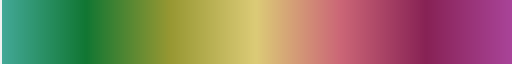

In [4]:
# Muted ColorMap
muted_cmap_name = "muted_cmap"
muted_qualitative_colors = [
    #(51/256, 34/256, 136/256),   # Indigo
    #(136/256, 204/256, 238/256), # Cyan
    (68/256, 170/256, 153/256),  # Teal
    (17/256, 119/256, 51/256),   # Green
    (153/256, 153/256, 51/256),  # Olive
    (221/256, 204/256, 119/256), # Sand
    (204/256, 102/256, 119/256), # Rose
    (136/256, 34/256, 85/256),   # Wine
    (170/256, 68/256, 153/256)]  # Purple

muted_cm = LinearSegmentedColormap.from_list(muted_cmap_name, muted_qualitative_colors)
newcolors = muted_cm(np.linspace(0, 1, 256))
silver_color = np.array([0.95, 0.95, 0.95, 1])
newcolors[0, :] = silver_color
muted_cmap = ListedColormap(newcolors)
muted_cmap

## 6. Define Mapping Functions, Define total Extent, and Choose Data Variable

This section defines the Extent for the later graphs, declares the data variable to look at, and then defines two utility functions.

In [5]:
# This utility function will simplify some code blocks later.
def get_geo_mask(lon, lat):
    lon_mask = (lon > extent[0]) & (lon < extent[1])
    lat_mask = (lat > extent[2]) & (lat < extent[3])
    return lon_mask & lat_mask

# This utility function will simplify some code blocks later.
def get_data_arrays(a_timestep: int):
    geo_mask = get_geo_mask(mfds['Longitude'][a_timestep, :, :], mfds['Latitude'][a_timestep, :, :]).compute().values
    lon_values = mfds['Longitude'][a_timestep, :, :].where(geo_mask).values
    lat_values = mfds['Latitude'][a_timestep, :, :].where(geo_mask).values
    var_values = mfds[data_variable][a_timestep, :, :].where(geo_mask).values
    timestamp = datetime.strptime(
        np.datetime_as_string(mfds['time'][a_timestep].values, unit='ms'),
        "%Y-%m-%dT%H:%M:%S.%f"
    )

    # Replace any +inf or -inf values with NaN.
    var_values[np.isinf(var_values)] = np.nan

    return lon_values, lat_values, var_values, timestamp

In [6]:
# Defines Extent for greater specificatoin
extent = [-79, -73, 35, 39.5]               # extend = [minLon, maxLon, minLat, maxLat]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

In [7]:
# Declare the desired Data Variable
data_variable = "UVAerosolIndex"   

## 7. Make A Before and During Timestep UVAI Map

This section creates timestep maps for before and during the peak of the smoke extent in hampton roads.

In [8]:
# country boundaries
country_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale="50m", facecolor='none', edgecolor='k')

# province boundaries
provinc_bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines', scale="50m", facecolor='none', edgecolor='k')

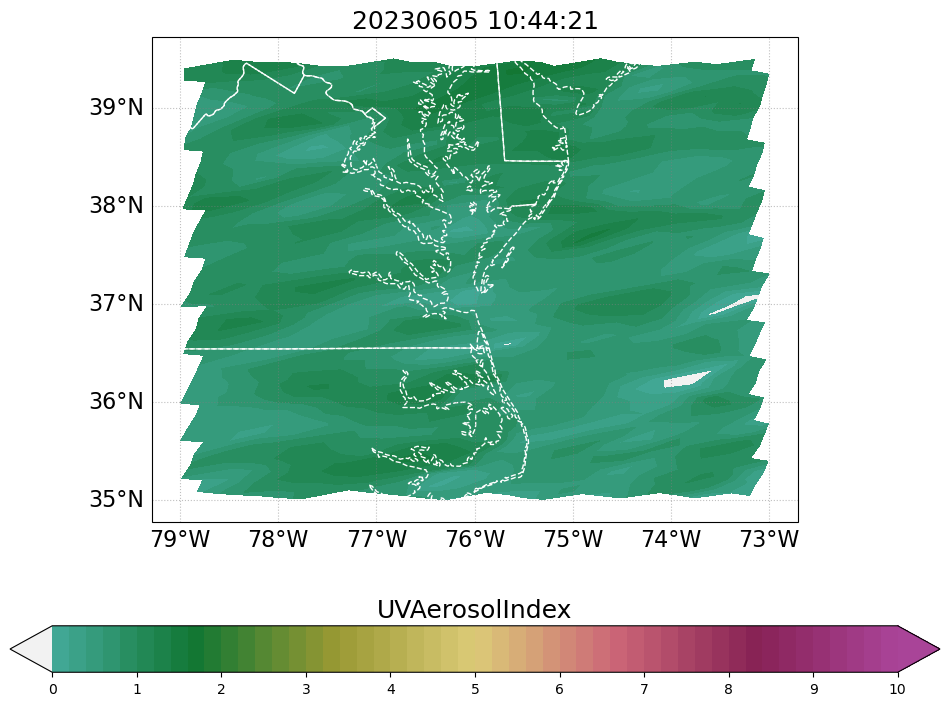

In [9]:
# Choose the timestep here. Timestep 30 shows clean air before the smoke arrived.
timestep01 = 30

# Get value range for the single timestep
values_min = 0  
values_max = 10

# Get the data arrays for the selected timestep
geo_mask = get_geo_mask(mfds['Longitude'][timestep01, :, :], mfds['Latitude'][timestep01, :, :]).compute().values

lon_values = mfds['Longitude'][timestep01, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep01, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep01, :, :].where(geo_mask).values
timestamp = datetime.strptime(
    np.datetime_as_string(mfds['time'][timestep01].values, unit='ms'),
    "%Y-%m-%dT%H:%M:%S.%f"
)

# Encoding the actual Plot
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=muted_cmap,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


plt.savefig("UVAerosolIndex/June05", bbox_inches="tight")
plt.show()

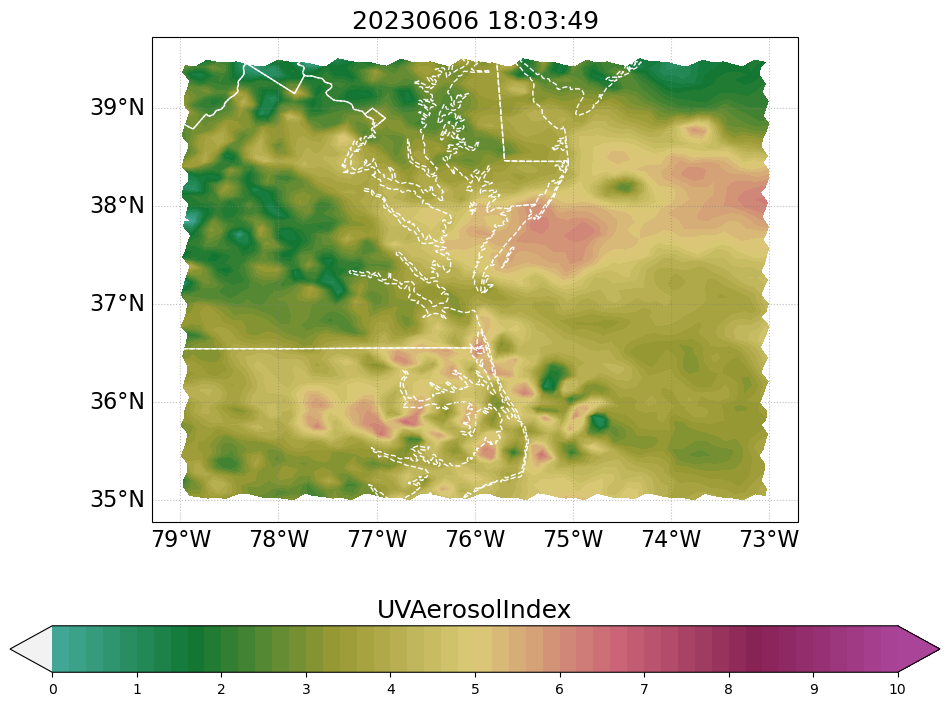

In [10]:
# Choose the timestep here. Timestep 48 shows dangerous levels of air quality as the smoke moved into the area.
timestep02 = 48

# Get value range for the single timestep
values_min = 0  
values_max = 10

# Get the data arrays for the selected timestep
geo_mask = get_geo_mask(mfds['Longitude'][timestep02, :, :], mfds['Latitude'][timestep02, :, :]).compute().values

lon_values = mfds['Longitude'][timestep02, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep02, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep02, :, :].where(geo_mask).values
timestamp = datetime.strptime(
    np.datetime_as_string(mfds['time'][timestep02].values, unit='ms'),
    "%Y-%m-%dT%H:%M:%S.%f"
)

# Encoding the actual Plot
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=muted_cmap,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


#plt.savefig("UVAerosolIndex/June06", bbox_inches="tight")
plt.show()

## 8. Change Data Variable, Create graphs for Final Aerosol Layer height

In [11]:
# Declare the desired Data Variable
data_variable = 'FinalAerosolLayerHeight'   

In [12]:
geo_mask = get_geo_mask(mfds['Longitude'][timestep01, :, :], mfds['Latitude'][timestep01, :, :]).compute().values

lon_values = mfds['Longitude'][timestep01, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep01, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep01, :, :].where(geo_mask).values   

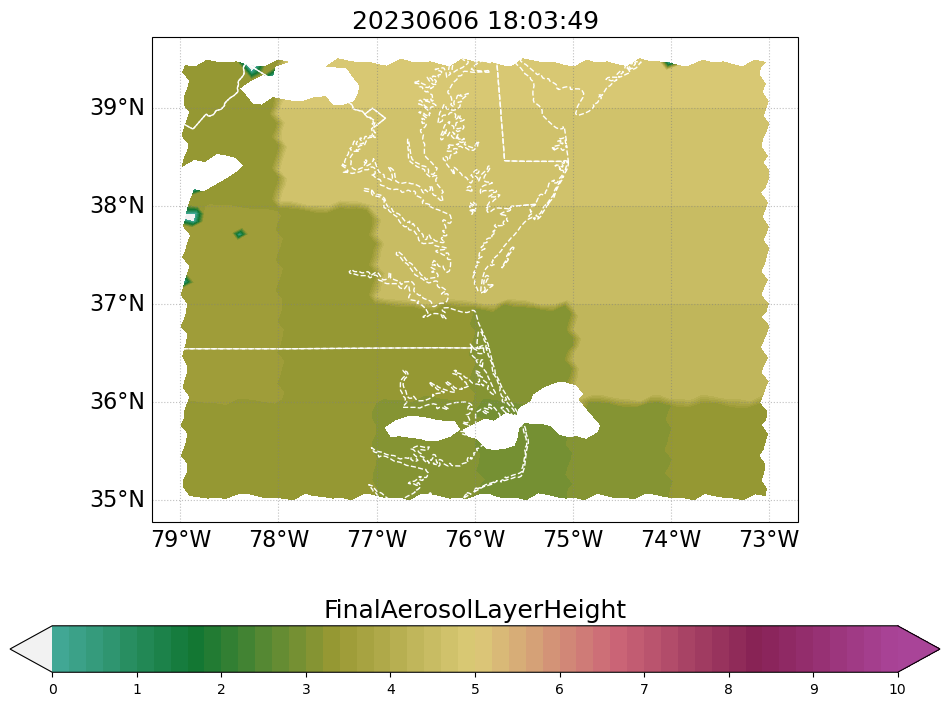

In [13]:
# Choose the timestep here. Timestep 30 shows clean air before the smoke arrived.
timestep01 = 48

# Get value range for the single timestep
values_min = 0  
values_max = 10

# Get the data arrays for the selected timestep
geo_mask = get_geo_mask(mfds['Longitude'][timestep01, :, :], mfds['Latitude'][timestep01, :, :]).compute().values

lon_values = mfds['Longitude'][timestep01, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep01, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep01, :, :].where(geo_mask).values
timestamp = datetime.strptime(
    np.datetime_as_string(mfds['time'][timestep01].values, unit='ms'),
    "%Y-%m-%dT%H:%M:%S.%f"
)

# Encoding the actual Plot
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=muted_cmap,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


plt.savefig("FinalAerosolLayerHeight/June06", bbox_inches="tight")
plt.show()

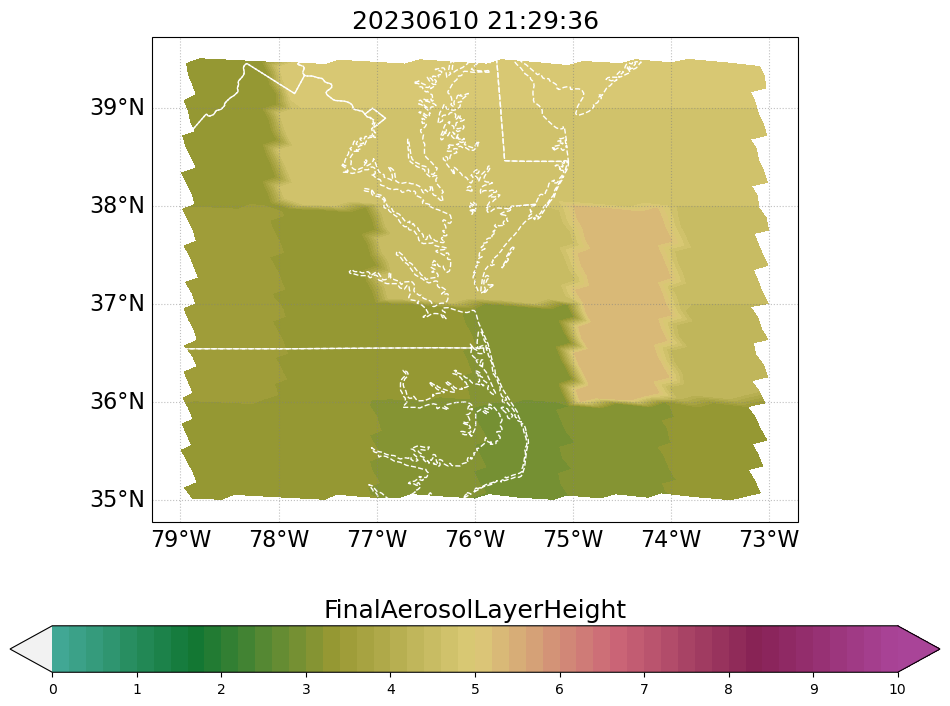

In [14]:
# Choose the timestep here. Timestep 30 shows clean air before the smoke arrived.
timestep01 = 99

# Get value range for the single timestep
values_min = 0  
values_max = 10

# Get the data arrays for the selected timestep
geo_mask = get_geo_mask(mfds['Longitude'][timestep01, :, :], mfds['Latitude'][timestep01, :, :]).compute().values

lon_values = mfds['Longitude'][timestep01, :, :].where(geo_mask).values
lat_values = mfds['Latitude'][timestep01, :, :].where(geo_mask).values
var_values = mfds[data_variable][timestep01, :, :].where(geo_mask).values
timestamp = datetime.strptime(
    np.datetime_as_string(mfds['time'][timestep01].values, unit='ms'),
    "%Y-%m-%dT%H:%M:%S.%f"
)

# Encoding the actual Plot
my_projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection}) #, "extent": extent})

vmin, vmax = values_min, values_max
levels = 50
level_boundaries = np.linspace(vmin, vmax, levels + 1)

_contourf = ax.contourf(lon_values, lat_values, var_values,
                        cmap=muted_cmap,  transform=ccrs.PlateCarree(),
                        levels=level_boundaries,
                        vmin=vmin, vmax=vmax, extend='both')

ax.add_feature(cfeature.STATES, linestyle='--', linewidth=1, edgecolor="w")

cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)
cb_handle.ax.set_title(data_variable, fontsize=18)

ax.set_title("%s" % (timestamp.strftime("%Y%m%d %H:%M:%S")), fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# We change the fontsize tick labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}


#plt.savefig("FinalAerosolLayerHeight/June10", bbox_inches="tight")
plt.show()

# Section 2: AQS and EPIC Comparisons

## 1. Generate Times and n_times, Create Getter Function for Hampton Roads Data

In [15]:
# Declare the desired Data Variable
data_variable = 'UVAerosolIndex'   

In [16]:
times = [datetime.strptime(np.datetime_as_string(t.values, unit='ms'), "%Y-%m-%dT%H:%M:%S.%f")
         for t in mfds['time']]

n_time = len(mfds.time)

In [17]:
def get_hampton_value(a_timestep: int, query_point_lon_lat: tuple):
    lon_values, lat_values, var_values, timestamp = get_data_arrays(a_timestep)

    lon_flat, lat_flat = lon_values.flatten(), lat_values.flatten()
    new2d = np.zeros((len(lon_flat), 2))
    for idx, (a, b) in enumerate(zip(lon_flat, lat_flat)):
        if not np.isnan(a):
            new2d[idx, :] = [a, b]

    nearestpt_distance, nearestpt_index = spatial.KDTree(new2d).query(query_point_lon_lat)

    nearestpt_coords = new2d[nearestpt_index, :]

    return nearestpt_distance, nearestpt_index, nearestpt_coords

**!!! Warning !!! This next cell can take a long time (e.g., +20 minutes).  It needs to be run once, but then should be commented-out.**

In [18]:
# Retrieve the Hampton values
# 36.9339° N, 76.3637° W
pt_hampton = [-76.3637, 37]

nearestpt_distances = []
nearestpt_indices = []
nearestpt_coords = []
for i in tqdm(range(n_time)):
    nearest_distance, nearest_index, nearest_coords = get_hampton_value(i, pt_hampton)
    nearestpt_distances.append(nearest_distance)
    nearestpt_indices.append(nearest_index)
    nearestpt_coords.append(nearest_coords)

  0%|          | 0/163 [00:00<?, ?it/s]

In [19]:
# Use MinMax Scores to remove Outliers
timeseries_values = []
times = []
    
#calculate the outliers
max_x = max(nearestpt_distances)
min_x = min(nearestpt_distances)

for i in tqdm(range(len(nearestpt_distances))):
    x = nearestpt_distances[i]
    xscore = (x-min_x)/(max_x-min_x)
    _, _, var_values, timestamp = get_data_arrays(i)
    
    if(xscore < 0.70):
        nearestpt_var_value = var_values.flatten()[nearestpt_indices[i]]
        if(nearestpt_var_value >= 0):
            timeseries_values.append(nearestpt_var_value)
            times.append(timestamp)

n_time = len(timeseries_values)
ntime=len(nearestpt_distances)
print("Original Number: ", ntime, "\nWithoutOutliers ", n_time)
    

  0%|          | 0/163 [00:00<?, ?it/s]

Original Number:  163 
WithoutOutliers  142


## 2. Use RSIG to get EPA Air Quality data from the same time period

In [20]:
hampton_roads_rsigapi = pyrsig.RsigApi(
    bdate='2023-06-02 00', 
    edate='2023-06-16 23:59:59',
    bbox = (-77, 36, -75, 38)  #Hampton Roads min lon, min lat, max lon, max lat
)

hampton_roads_aqsno2df = hampton_roads_rsigapi.to_dataframe('aqs.pm25', parse_dates=True, unit_keys=False)
hr_aqs_time = hampton_roads_aqsno2df.groupby(['time']).median(numeric_only=True)['pm25']

hr_aqs_latitude = hampton_roads_aqsno2df['LATITUDE']
hr_aqs_longitude = hampton_roads_aqsno2df['LONGITUDE']

Using cached: ./aqs.pm25_2023-06-02T000000Z_2023-06-16T235959Z.csv.gz


## 3. Make combined figure

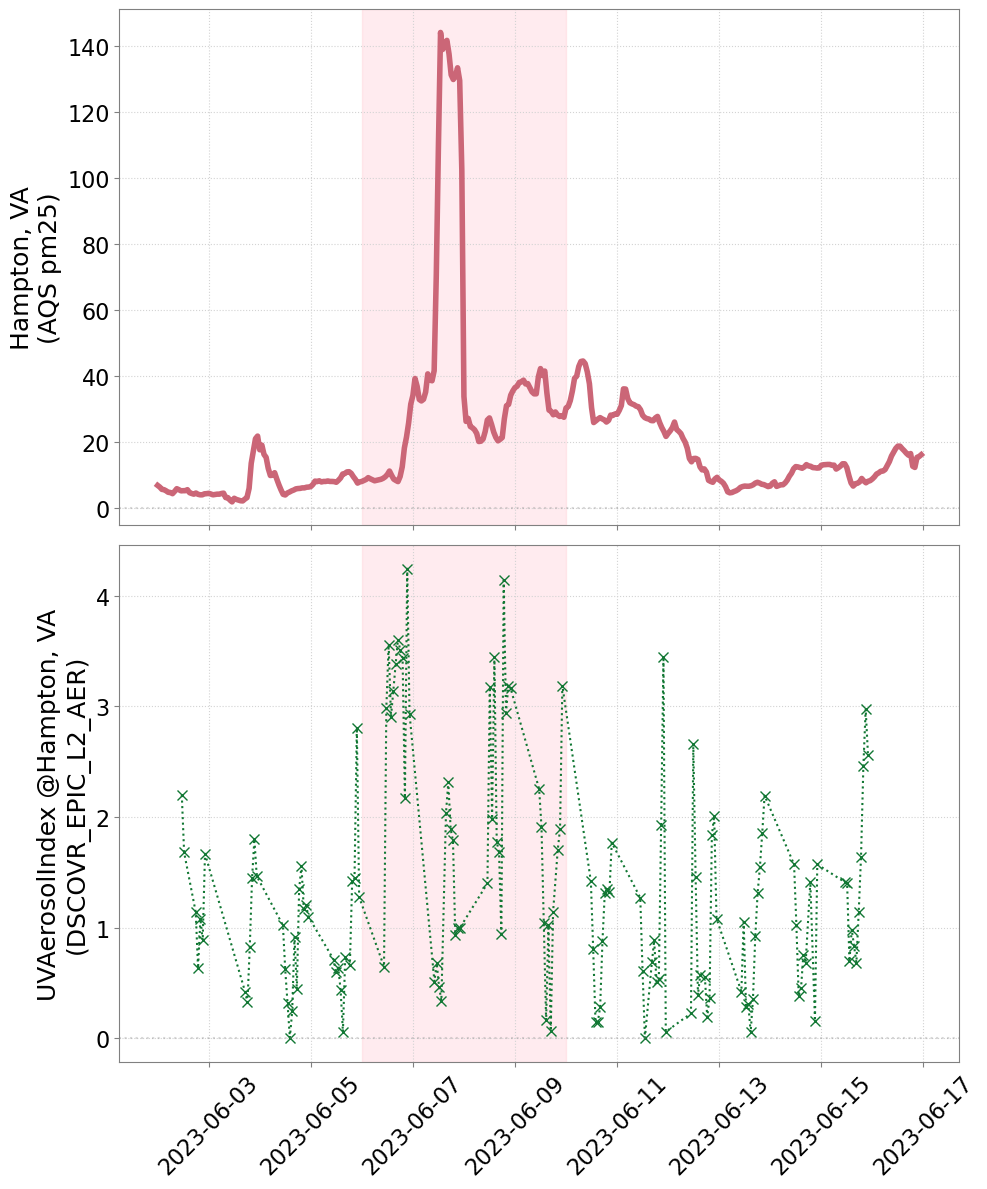

In [21]:
color_green = (17/256, 119/256, 51/256)   # Green
color_purple =  (204/256, 102/256, 119/256) # Rose

fig, axs = plt.subplots(figsize=(10, 12), nrows=2, ncols=1, sharex=True)

# Plot
axn = 0
axs[axn].plot(hr_aqs_time.index.values, hr_aqs_time.values,  markersize=9, linewidth=4, color=color_purple)
axs[axn].set_ylabel(f"Hampton, VA\n(AQS pm25)", fontsize=18, color='k')

axn = 1
axs[axn].plot(times, timeseries_values, ":x", markersize=7, color=color_green)
axs[axn].set_ylabel(f"{data_variable} @Hampton, VA\n(DSCOVR_EPIC_L2_AER)", fontsize=18, color="black")

# Change the aesthetics
for a in axs:
    a.axvspan(datetime(2023, 6, 6, 0, 0, 0), 
              datetime(2023, 6, 10, 0, 0, 0), 
              alpha=0.3, color='pink')
    a.axhline(0, linestyle=":", alpha=0.3, color="gray")
    
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=16)
    a.grid(visible=True, which='major', axis='both', color="lightgray", linestyle=":")

    a.tick_params(color='gray', labelcolor='black')
    for spine in a.spines.values():
        spine.set_edgecolor('gray')

plt.xticks(rotation=45)
plt.tight_layout()

#plt.savefig("DscovrFigures/01_dscovr_epic_uvai_with_AQS_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

## 4. Parsing the AQS Data to minimize time difference between points

In [22]:
from pandas import to_datetime
from cartopy.io.shapereader import Reader

import math
import statistics
from scipy import stats
from sklearn.metrics import mean_squared_error

def get_normalized_data(data):
    max_pt = max(data)
    min_pt = min(data)

    for i in range(len(data)): 
        x = data[i]
        data[i] = (x-min_pt)/(max_pt-min_pt)
    return data

def get_date_splits(data, times):
    before = []
    during = []
    after = []
    
    day1 = datetime(2023, 6, 6, 0, 0, 0)
    day2 = datetime(2023, 6, 10, 0, 0, 0)
    
    for i in range(len(times)):
        curr_day = times[i]
        if(curr_day < day1):
            before.append(data[i])
        elif(curr_day < day2):
            during.append(data[i])
        else:
            after.append(data[i])

    return before, during, after

In [23]:
# Because there are more points from the EPA I am going to remove some
aqs_Times = []
aqs_Values = []
aqs_Lats = []
aqs_Longs = []

aqs_Count = 12 # Here the EPA data catches up to the DSCOVR Data
current = to_datetime(hr_aqs_time.index.values[aqs_Count])
total_error = 0

for i in range(len(times)):
    x = times[i]
    while current < x:
        aqs_Count += 1
        current = to_datetime(hr_aqs_time.index.values[aqs_Count])

    prev = to_datetime(hr_aqs_time.index.values[aqs_Count]-1)
    prev_difference = x - prev
    current_difference = current - x

    if(current_difference < prev_difference):
        aqs_Times.append(to_datetime(hr_aqs_time.index.values[aqs_Count]))
        aqs_Values.append(hr_aqs_time.values[aqs_Count])
        aqs_Lats.append(hr_aqs_latitude.values[aqs_Count])
        aqs_Longs.append(hr_aqs_longitude.values[aqs_Count])
    else:
        aqs_Times.append(to_datetime(hr_aqs_time.index.values[aqs_Count-1]))
        aqs_Values.append(hr_aqs_time.values[aqs_Count-1])
        aqs_Lats.append(hr_aqs_latitude.values[aqs_Count-1])
        aqs_Longs.append(hr_aqs_longitude.values[aqs_Count-1])
    

In [24]:
normalized_dscovr = get_normalized_data(timeseries_values)
normalized_aqs = get_normalized_data(aqs_Values)

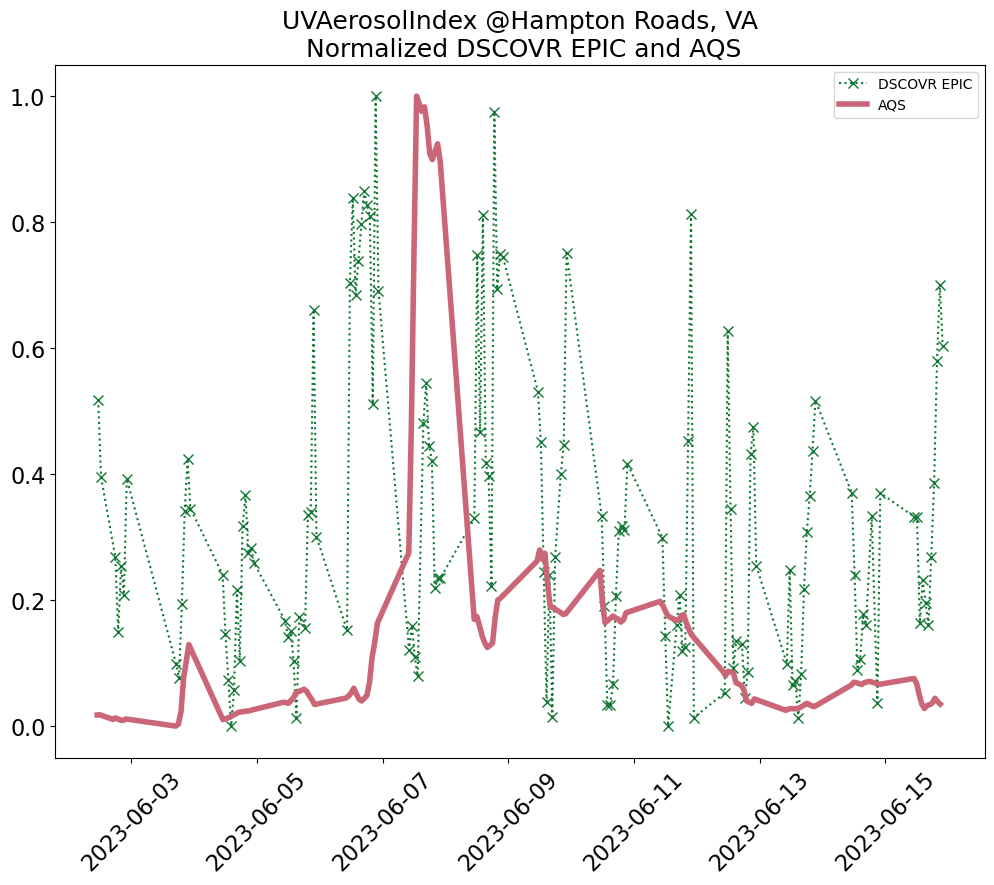

In [25]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(times, normalized_dscovr, ":x", markersize=7, color=color_green, label="DSCOVR EPIC")
ax.plot(aqs_Times, normalized_aqs, markersize=9, linewidth=4, color=color_purple, label="AQS")
ax.legend()

ax.set_title(f"{data_variable} @Hampton Roads, VA\n Normalized DSCOVR EPIC and AQS", fontsize=18)

# Detailing the axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)

#plt.savefig("DscovrFigures/02_UVAI_Initial_Comparison.png", dpi=200, bbox_inches="tight")
plt.show()

## 5. RSIG and DSCOVR EDA 

In [26]:
# splitting
dscovr_before, dscovr_during, dscovr_after = get_date_splits(normalized_dscovr, times)
aqs_before, aqs_during, aqs_after = get_date_splits(normalized_aqs, aqs_Times)

# calculating RSME
total_rsme = math.sqrt(mean_squared_error(normalized_aqs, normalized_dscovr))
before_rsme = math.sqrt(mean_squared_error(aqs_before, dscovr_before))
during_rsme = math.sqrt(mean_squared_error(aqs_during, dscovr_during))
after_rsme = math.sqrt(mean_squared_error(aqs_after, dscovr_after))

print("RSME Total:\t\t\t", total_rsme)
print("RSME Before:\t\t\t", before_rsme)
print("RSME During:\t\t\t", during_rsme)
print("RSME After:\t\t\t", after_rsme)

# Calculating Variance
dscovr_xbar = sum(normalized_dscovr)/len(normalized_dscovr)
var_dscovr = statistics.variance(normalized_dscovr, dscovr_xbar)

print("\nDSCOVR Normalized Variance:\t", var_dscovr)
print("Variance Before:\t\t", statistics.variance(dscovr_before, dscovr_xbar))
print("Variance During:\t\t", statistics.variance(dscovr_during, dscovr_xbar))
print("Variance After:\t\t\t", statistics.variance(dscovr_after, dscovr_xbar))

aqs_xbar = sum(normalized_aqs)/len(normalized_aqs)
var_aqs = statistics.variance(normalized_aqs, aqs_xbar)

print("\nEPA Normalized Variance:\t", var_aqs)
print("Variance Before:\t\t", statistics.variance(aqs_before, aqs_xbar))
print("Variance During:\t\t", statistics.variance(aqs_during, aqs_xbar))
print("Variance After:\t\t\t", statistics.variance(aqs_after, aqs_xbar))

RSME Total:			 0.3621721062919453
RSME Before:			 0.24617253710142142
RSME During:			 0.5324155967958419
RSME After:			 0.25310309265303943

DSCOVR Normalized Variance:	 0.055642726556219345
Variance Before:		 0.027688780178368674
Variance During:		 0.10532021346875481
Variance After:			 0.03848767145946832

EPA Normalized Variance:	 0.047360978079059826
Variance Before:		 0.013918644754007578
Variance During:		 0.13407293088738306
Variance After:			 0.0069772018786835805


### Is Location the Issue?

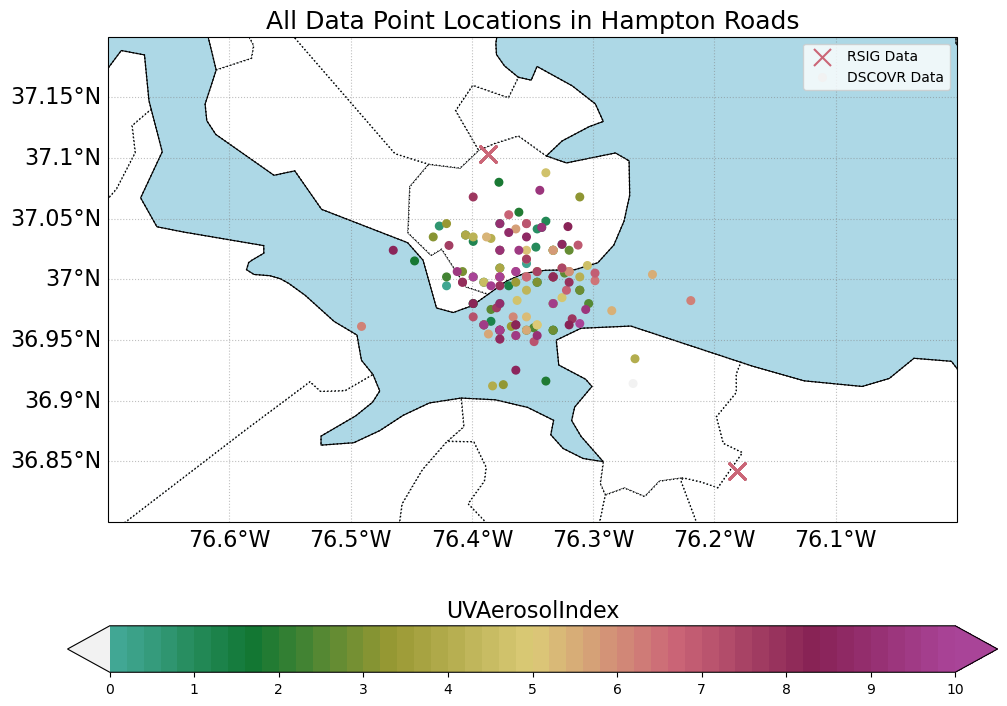

In [28]:
# Separating the Coordinates into Latitude and Longitude Arrays for ease
dscovr_lats = []
dscovr_longs = []

for val in nearestpt_coords:
    dscovr_lats.append(val[1])
    dscovr_longs.append(val[0])

# Building the Projection
my_projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={"projection": my_projection})
ax.set_facecolor('lightblue')

# Calling the County level data to build the outline
county_shapefile = 'content/cartopy_data/cultural/ne_10m_admin_2_counties.shp'
counties = cfeature.ShapelyFeature(Reader(county_shapefile).geometries(), my_projection, facecolor='white', edgecolor="k")
ax.add_feature(counties, linestyle=':', zorder=0)

ax.set_extent([-76.7,-76, 36.8, 37.2], crs=my_projection)
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.8, edgecolor="k", zorder=1)

# Putting the actual data onto the graph
ax.scatter(aqs_Longs, aqs_Lats, marker='x', s=150, color=color_purple, zorder=2, label = "RSIG Data")
ax.scatter(dscovr_longs, dscovr_lats, marker='o', s=30, data=timeseries_values, c=np.arange(len(dscovr_longs)), cmap=muted_cmap, zorder=3, label='DSCOVR Data')
ax.legend()

# Adding the colorbar
cb_handle = plt.colorbar(
    _contourf,
    orientation="horizontal",
    ticks=range(int(np.floor(vmin)), int(np.ceil(vmax+1)), 1),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)

cb_handle.ax.set_title(data_variable, fontsize=16)

ax.set_title('All Data Point Locations in Hampton Roads', fontsize=18)

gl_handle = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'], 
             linewidth=0.8, color='gray', alpha=0.5, linestyle=':')

# Detailing the axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
cb_handle.ax.tick_params(axis='both', which='minor', labelsize=16)
gl_handle.xlabel_style, gl_handle.ylabel_style = {'fontsize': 16}, {'fontsize': 16}

#plt.savefig("DscovrFigures/03_Locations_Graph", bbox_inches="tight")
plt.show()

Slope:		 0.02159341276259174
Intercept:	 0.31821650329746387
R Value:	 0.01992174681799828
P Value:	 0.813960289726497
Standard Error:	 0.09158907113393104


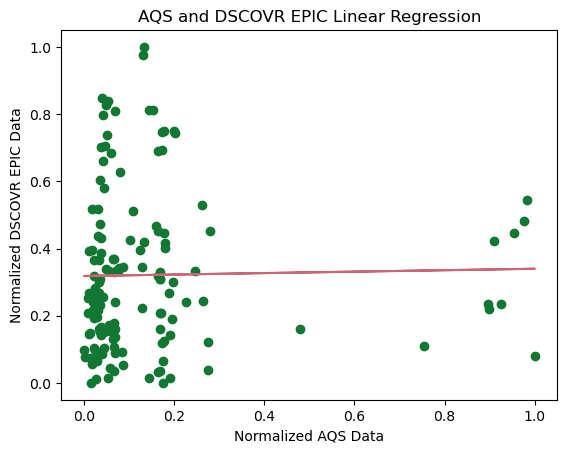

In [29]:
slope, intercept, r_val, p_val, std_err = stats.linregress(normalized_aqs, normalized_dscovr)

print("Slope:\t\t", slope)
print("Intercept:\t", intercept)
print("R Value:\t", r_val)
print("P Value:\t", p_val)
print("Standard Error:\t", std_err)

plt.scatter(normalized_aqs, normalized_dscovr, color=color_green)
plt.plot(normalized_aqs, slope * np.array(normalized_aqs) + intercept, color=color_purple)

plt.title('AQS and DSCOVR EPIC Linear Regression')
plt.xlabel('Normalized AQS Data')
plt.ylabel('Normalized DSCOVR EPIC Data')
#plt.savefig("DscovrFigures/04_Initial_Linear_Regression", bbox_inches="tight")
plt.show()

## 6. Minimizing Error by shifting AQS time

In [31]:
best_timeshift_dscovr = []
best_timeshift_aqs = []

min_rsme = 1
best_dilation = 0
for i in range(int(len(normalized_aqs)/3)):
    timeshift_normalized_aqs = normalized_aqs[i:len(normalized_aqs)]
    timeshift_normalized_dscovr = normalized_dscovr[0:len(normalized_dscovr)-i]

    curr_rsme =  math.sqrt(mean_squared_error(timeshift_normalized_aqs, timeshift_normalized_dscovr))
    if(curr_rsme < min_rsme):
        min_rsme = curr_rsme
        best_dilation = i

        best_timeshift_dscovr = timeshift_normalized_dscovr
        best_timeshift_aqs = timeshift_normalized_aqs       

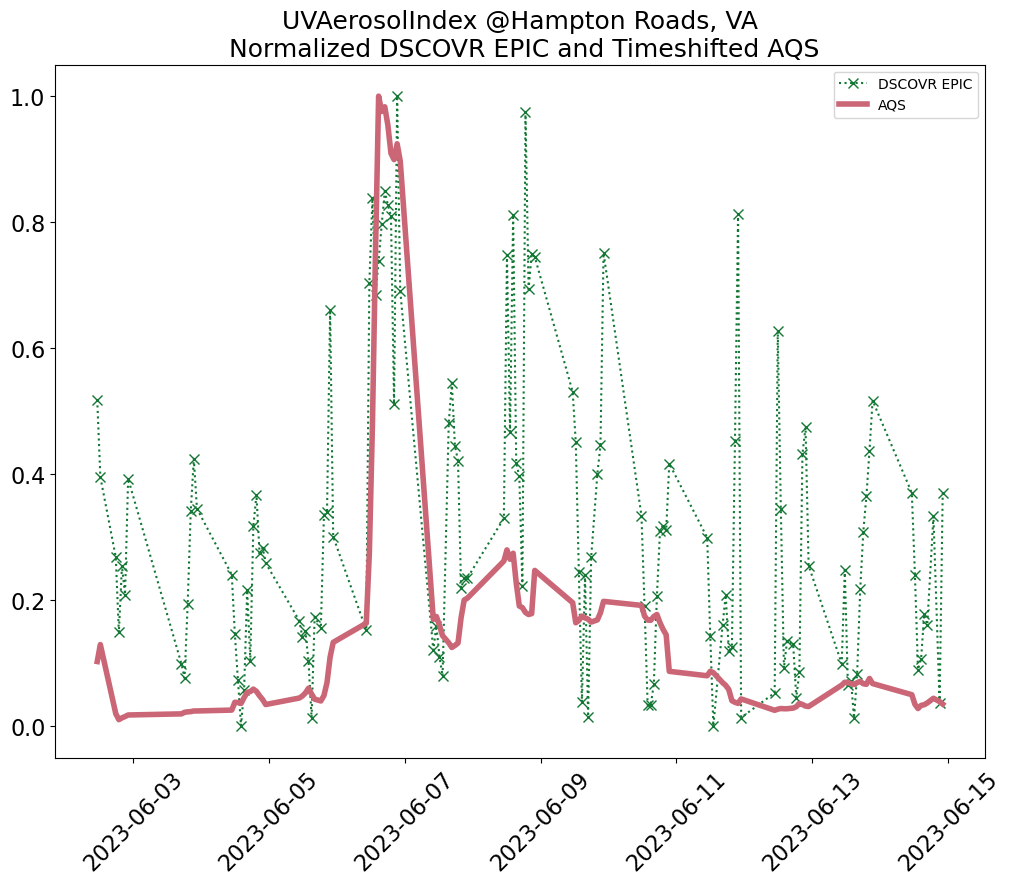

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(times[0:len(times)-best_dilation], best_timeshift_dscovr, ":x", markersize=7, color=color_green, label="DSCOVR EPIC")
ax.plot(times[0:len(times)-best_dilation], best_timeshift_aqs, markersize=9, linewidth=4, color=color_purple, label="AQS")
ax.legend()

ax.set_title(f"{data_variable} @Hampton Roads, VA\n Normalized DSCOVR EPIC and Timeshifted AQS", fontsize=18)

# Detailing the axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)

#plt.savefig("DscovrFigures/05_UVAI_Timeshift_Comparison.png", dpi=200, bbox_inches="tight")
plt.show()

In [36]:
dscovr_before, dscovr_during, dscovr_after = get_date_splits(best_timeshift_dscovr, times[0:len(times)-best_dilation])
aqs_before, aqs_during, aqs_after = get_date_splits(normalized_aqs, times[0:len(times)-best_dilation])

# calculating RSME
total_rsme = math.sqrt(mean_squared_error(best_timeshift_aqs, best_timeshift_dscovr))
before_rsme = math.sqrt(mean_squared_error(aqs_before, dscovr_before))
during_rsme = math.sqrt(mean_squared_error(aqs_during, dscovr_during))
after_rsme = math.sqrt(mean_squared_error(aqs_after, dscovr_after))

print("RSME Total:\t\t\t", total_rsme)
print("RSME Before:\t\t\t", before_rsme)
print("RSME During:\t\t\t", during_rsme)
print("RSME After:\t\t\t", after_rsme)

# Calculating Variance
timeshift_dscovr_xbar = sum(best_timeshift_dscovr)/len(best_timeshift_dscovr)
timeshift_var_dscovr = statistics.variance(best_timeshift_dscovr, timeshift_dscovr_xbar)

print("\nDSCOVR Normalized Variance:\t", timeshift_var_dscovr)
print("Variance Before:\t\t", statistics.variance(dscovr_before, timeshift_dscovr_xbar))
print("Variance During:\t\t", statistics.variance(dscovr_during, timeshift_dscovr_xbar))
print("Variance After:\t\t\t", statistics.variance(dscovr_after, timeshift_dscovr_xbar))

timeshift_aqs_xbar = sum(best_timeshift_aqs)/len(best_timeshift_aqs)
timeshift_var_aqs = statistics.variance(best_timeshift_aqs, timeshift_aqs_xbar)

print("\nAQS Normalized Variance:\t", timeshift_var_aqs)
print("Variance Before:\t\t", statistics.variance(aqs_before, timeshift_aqs_xbar))
print("Variance During:\t\t", statistics.variance(aqs_during, timeshift_aqs_xbar))
print("Variance After:\t\t\t", statistics.variance(aqs_after, timeshift_aqs_xbar))

RSME Total:			 0.2595792207779648
RSME Before:			 0.24617253710142142
RSME During:			 0.5324155967958419
RSME After:			 0.22211796472527054

DSCOVR Normalized Variance:	 0.057484233771835994
Variance Before:		 0.027147977698885658
Variance During:		 0.10643757686522985
Variance After:			 0.03891910731345595

AQS Normalized Variance:	 0.0498312886998039
Variance Before:		 0.016541150756888348
Variance During:		 0.13045356293082017
Variance After:			 0.0072684161863313616


Slope:		 0.6605164502718359
Intercept:	 0.21494925405731322
R Value:	 0.6149790541384347
P Value:	 5.522770035203055e-15
Standard Error:	 0.07456827287499768


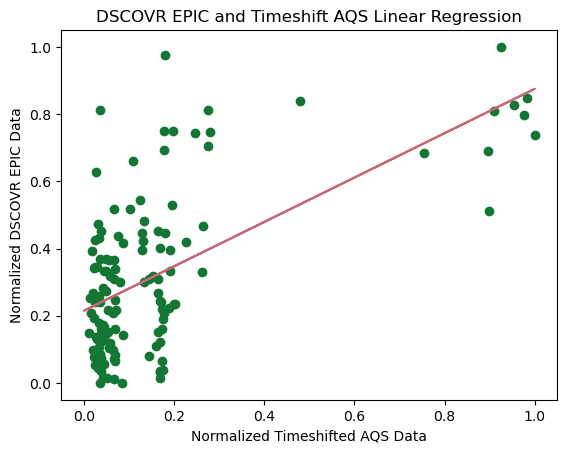

In [39]:
slope, intercept, r_val, p_val, std_err = stats.linregress(best_timeshift_aqs, best_timeshift_dscovr)

print("Slope:\t\t", slope)
print("Intercept:\t", intercept)
print("R Value:\t", r_val)
print("P Value:\t", p_val)
print("Standard Error:\t", std_err)

plt.scatter(best_timeshift_aqs, best_timeshift_dscovr, color=color_green)
plt.plot(normalized_aqs, slope * np.array(normalized_aqs) + intercept, color=color_purple)

plt.title('DSCOVR EPIC and Timeshift AQS Linear Regression')
plt.xlabel('Normalized Timeshifted AQS Data')
plt.ylabel('Normalized DSCOVR EPIC Data')
#plt.savefig("DscovrFigures/06_Timeshift_Linear_Regression", bbox_inches="tight")
plt.show()

END of Notebook.